# Steps Performed : 

1. Feature Scaling
2. Dimensionality reduction using AutoEncoders
3. Machine Learning Models with evaluation report

# Pre-requisite:
    Ensure datafolder and required csv datafile is in place before running the code.
    If you are running this notebook into Jupyter notebook, ensure to mount the drive and file exists on the drive

In [2]:
#Modify the directory & File name based on your local paths & file name
dataFolder = "C:/Users/shaaruns.CORPDOM/Documents/BITS_Assignments/Module-7/Gr20_Cap4_Sourcecode/Grp20_Cohert3_Final_Submission"
datafile = "Output_CSV/Dataset_Step4_Processed_Data.csv"

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#The reason for giving version details is to provide information about libraries where the code has been tested. 
import pandas as pd
print('pandas  : {}'.format(pd.__version__))  
import numpy as np
print ('numpy   : {}'.format(np.__version__))

#Scaling Libraries
from sklearn.preprocessing import StandardScaler

#Feature Reduction libraries
from sklearn.decomposition import PCA

#Split the dataset into test & train
from sklearn.model_selection import train_test_split, GridSearchCV

#Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC

#Model Evaluation Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

#Data Visualization
import matplotlib.pyplot as plt


# Multilayer Perceptron
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from tensorflow.keras.models import load_model


pandas  : 1.1.5
numpy   : 1.19.5


In [5]:
#Read the dataset from clean datafile

#df_train = pd.read_csv(dataFolder+'/'+ datafile)
#df_train.head()

#Read the dataset from GDrive
Inputfile = 'drive/My Drive/Capstone_Files/Dataset_Step4_Processed_Data_Revised.csv'
df_train = pd.read_csv(Inputfile)
df_train.head()



,Consumerdisputed,ComplaintID,Month_Received,Year_Sent,Month_Sent,Day_Sent,Week_Received,Product_Consumer Loan,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Mortgage,Product_Student loan,Submittedvia_Fax,Submittedvia_Phone,Submittedvia_Postal mail,Submittedvia_Referral,Submittedvia_Web,Companyresponsetoconsumer_Closed with explanation,Companyresponsetoconsumer_Closed with monetary relief,Companyresponsetoconsumer_Closed with non-monetary relief,Companyresponsetoconsumer_Closed with relief,Companyresponsetoconsumer_Closed without relief,Timelyresponse_Yes,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,Feature16,...,Feature79,Feature80,Feature81,Feature82,Feature83,Feature84,Feature85,Feature86,Feature87,Feature88,Feature89,Feature90,Feature91,Feature92,Feature93,Feature94,Feature95,Feature96,Feature97,Feature98,Feature99,Feature100,Feature101,Feature102,Feature103,Feature104,Feature105,Feature106,Feature107,Feature108,Feature109,Feature110,Feature111,Feature112,Feature113,Feature114,Feature115,Feature116,Feature117,Feature118
0,1,1347613,4,2015,4,26,4,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0
1,1,1685130,12,2015,12,7,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.799826,0.0,0.0,0.0,0.0,0.600232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,1,10631,1,2012,1,9,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0.0,0.0,0.0,0.0,0.497837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500719,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,1,1489180,7,2015,7,27,4,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.556499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.587498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,1,795636,4,2014,4,6,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


# Feature Scaling of train Data Sets except Target and Indent variable

In [6]:
df_train.shape

(100311, 142)

In [7]:
df_train.rename(columns = {'Complaint ID':'ComplaintID'}, inplace = True)

In [8]:
temp = df_train.copy()

In [9]:
colsTobedropped = ['Consumerdisputed', 
                  'ComplaintID'
                   ]

#Dropping Target Featyer & Unique Complaint ID for scaling operation

temp  = temp.drop(colsTobedropped,axis = 1)
print(temp.columns)

Index(['Month_Received', 'Year_Sent', 'Month_Sent', 'Day_Sent',
       'Week_Received', 'Product_Consumer Loan', 'Product_Credit card',
       'Product_Credit reporting', 'Product_Debt collection',
       'Product_Mortgage',
       ...
       'Feature109', 'Feature110', 'Feature111', 'Feature112', 'Feature113',
       'Feature114', 'Feature115', 'Feature116', 'Feature117', 'Feature118'],
      dtype='object', length=140)


In [10]:
temp.shape

(100311, 140)

In [11]:
scaledCols = temp.columns

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_train[scaledCols] = scaler.fit_transform(df_train[scaledCols])

In [13]:
df_train.shape

(100311, 142)

In [14]:
#Final X training Data
X = df_train.reindex(columns=scaledCols)

#Target Y Variable Consumer disputed as 0 or 1
y = df_train['Consumerdisputed'].values

#Preserving ComplaintID for providing final output results, will not be used for training data
p_ComplaintID = df_train['ComplaintID'].values

In [15]:
# Split the dataframe 80:20 preserve the distribution of class - use stratify

X_train, X_test, y_train, y_test , trainComplaintID , valComplaintID = train_test_split(X, y, p_ComplaintID , test_size = 0.2,random_state = 17 , stratify = df_train['Consumerdisputed'])


In [16]:
#checking y_train distribution
print("y_train distribution of label '1': {} \n".format(sum(y_train == 1))) 
print("y_train distribution of label '0': {} \n".format(sum(y_train == 0)))


#checking y_train distribution
print("y_val distribution of label '1': {} \n".format(sum(y_test == 1))) 
print("y_val distribution of label '0': {} \n".format(sum(y_test == 0)))

y_train distribution of label '1': 24541 

y_train distribution of label '0': 55707 

y_val distribution of label '1': 6136 

y_val distribution of label '0': 13927 



# Dimensional reduction and features selection

# Using AutoEncoder

An autoencoder is composed of an encoder and a decoder sub-models. The encoder compresses the input and the decoder attempts to recreate the input from the compressed version provided by the encoder. After training, the encoder model is saved and the decoder is discarded.
The encoder can then be used as a data preparation technique to perform feature extraction on raw data that can be used to train a different machine learning model.

In [17]:
totalFeature = X_train.columns
len(totalFeature)

140

# Autoencoder for reconstructing the input data for a classification dataset with 50% compression in the bottleneck layer/

In [18]:
n_inputs = len(totalFeature)
# define encoder
visible = Input(shape=(n_inputs,))

#We will use batch normalization and leaky ReLU activation.
#The encoder to have two hidden layers, 
#The first with two times the number of inputs 
#The second with the same number of inputs 
#The bottleneck layer with the half the number of inputs as the dataset.

# encoder level 1
e = Dense(n_inputs*2)(visible)

#Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster 
#and more stable through normalization of the input layer by re-centering and re-scaling.
e = BatchNormalization()(e)

#In the context of artificial neural networks, 
#the rectifier is an activation function defined as the positive part of its argument:
#f(x)=max(0,x) where x is the input to a neuron. 
e = LeakyReLU()(e)


# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)


# bottleneck
#The bottleneck layer with the half the number of inputs as the dataset.
n_bottleneck = round(float(n_inputs) / 2.0) #Half of the input 
bottleneck = Dense(n_bottleneck)(e)

In [19]:
#The decoder will be defined with a similar structure, although in reverse.
# define decoder, level 1

d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(n_inputs, activation='softmax')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [20]:
# compile autoencoder model

#The model will be fit using the efficient Adam version of stochastic gradient descent and 
#minimizes the mean squared error, given that reconstruction is a type of multi-output regression problem.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


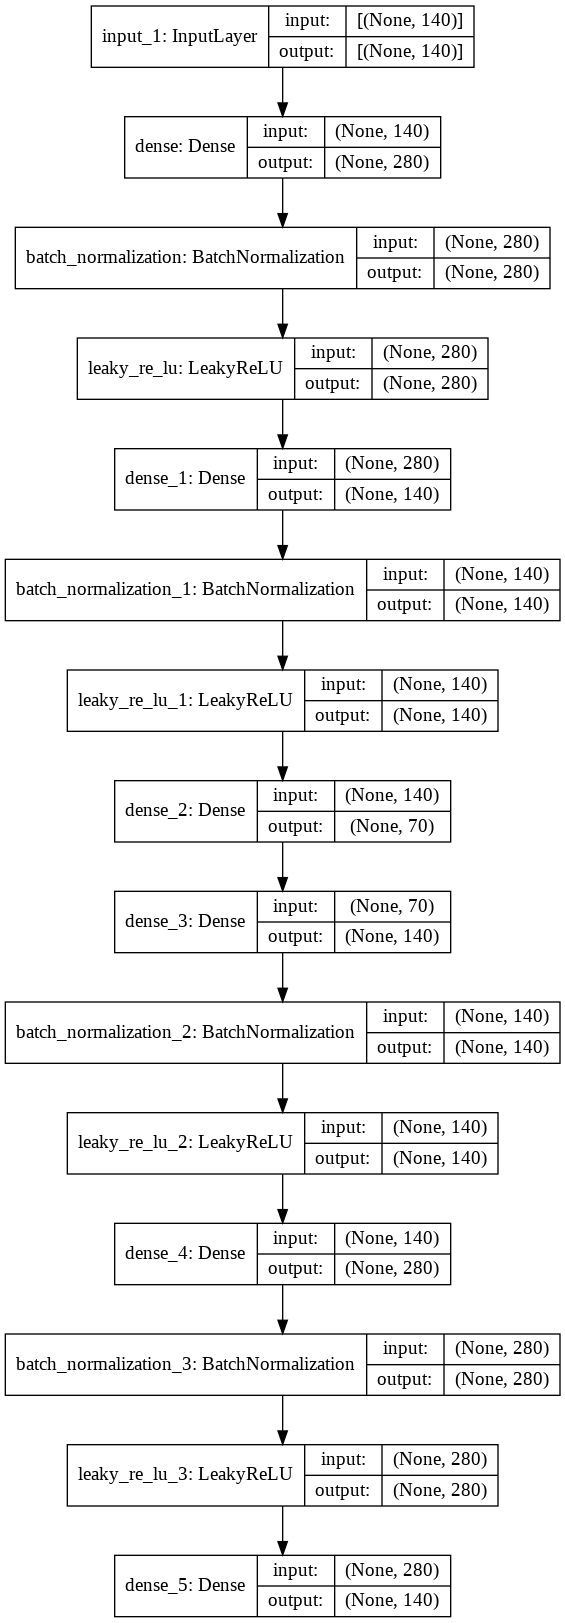

In [21]:
# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)

In [22]:
...
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Epoch 1/200
5016/5016 - 33s - loss: 6384.6040 - accuracy: 0.0910 - val_loss: 17973.0020 - val_accuracy: 0.0508
Epoch 2/200
5016/5016 - 29s - loss: 35236.1758 - accuracy: 0.0633 - val_loss: 48903.8359 - val_accuracy: 0.0825
Epoch 3/200
5016/5016 - 28s - loss: 80456.4844 - accuracy: 0.0575 - val_loss: 102042.5312 - val_accuracy: 0.0812
Epoch 4/200
5016/5016 - 28s - loss: 142416.9531 - accuracy: 0.0556 - val_loss: 175530.4219 - val_accuracy: 0.0662
Epoch 5/200
5016/5016 - 28s - loss: 223360.9062 - accuracy: 0.0533 - val_loss: 253367.4531 - val_accuracy: 0.0648
Epoch 6/200
5016/5016 - 28s - loss: 322183.3750 - accuracy: 0.0583 - val_loss: 376559.4375 - val_accuracy: 0.0937
Epoch 7/200
5016/5016 - 28s - loss: 442843.0312 - accuracy: 0.0606 - val_loss: 528265.5625 - val_accuracy: 0.0796
Epoch 8/200
5016/5016 - 28s - loss: 577293.5000 - accuracy: 0.0647 - val_loss: 604398.4375 - val_accuracy: 0.1082
Epoch 9/200
5016/5016 - 28s - loss: 726742.9375 - accuracy: 0.0669 - val_loss: 755400.0625 - v

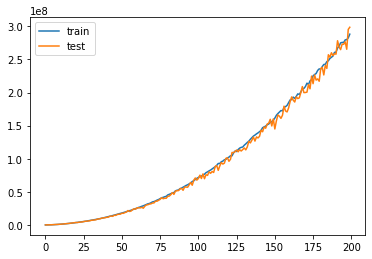

In [23]:
#After training, we can plot the learning curves for the train and test sets to confirm the model learned the 
#reconstruction problem well

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)

# save the encoder to file
encoder.save('encoder_Step6.h5')

# Encoder as Data Preparation for Predictive Model

In [25]:
# load the model from file
encoder = load_model('encoder_Step6.h5')

In [26]:
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)


In [27]:
SKLearn_Model_Data = {}
Model_accuracy = {}

In [28]:
#Funtion to plot ROC curve
def plot_roc_curve(model, yTest, yPred):
    fpr, tpr, thresholds = roc_curve(yTest, yPred)
    roc_auc = auc(fpr, tpr)
    lw = 2
    Model_accuracy[model] = roc_auc_score(yTest,yPred)
    print('AUC roc_auc_score:', roc_auc_score(yTest,yPred))
    plt.plot([0,1],[0,1],'k--')
    #plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    
    #Plot tthe ROC Curve with FPR & TPR as X & Y axis
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('fpr') #False Postive Rate
    plt.ylabel('tpr') #True Positive Rate 
    plt.title(model)
    plt.show()

#Funtion to create the Model Evaluation Report
def getModelReport(modelName, yTest, yPredict) :
    #Accuracy can be a misleading metric for imbalanced data sets
    accuracy = accuracy_score(yTest, yPredict) 
    
    #fraction of retrieved documents that are relevant to the query
    precision = precision_score(yTest, yPredict)
    
    #fraction of the relevant documents that are successfully retrieved.
    recall = recall_score(yTest, yPredict)
    
    #A measure that combines precision and recall is the harmonic mean of precision and recall, 
    #the traditional F-measure or balanced F-score
    
    f1 = f1_score(yTest, yPredict)
    
    # Confusion Matrix , a specific table layout that allows visualization of the performance of an algorithm
    conf_matrix = confusion_matrix(yTest, yPredict)
    clf_report = classification_report(yTest, yPredict)

    print('\n\n*************************************************************************************')
    print('FOR {0}:'.format(modelName))
    print('TEST ACCURACY:', accuracy)
    print('F1 SCORE:', f1)
    print('CONFUSION MATRIX: ')
    print(conf_matrix)
    print('CLASSIFICATION REPORT: ')
    print(clf_report)
    print('****************************************************************************************')


In [29]:
def predict_with_decisionTree(X_train, y_train, X_test):
    """
    This method creates a model using Decision Tree classifier and predicts the output
    X_train: The training data set
    y_train: The label of training data set
    X_test: The test data set
    """
    
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train.ravel())
    decisionTree_y_predict_train = model.predict(X_train)
    train_acc = accuracy_score(y_train, decisionTree_y_predict_train)
    print ("Decision Tree: TRAIN ACCURACY: ",train_acc )
    forest_y_predict = model.predict(X_test)

    dt_y_predict = model.predict(X_test)
    return dt_y_predict

def predict_with_SVM(X_train, y_train, X_test):
    """
    This method creates a model using SVM classifier and predicts the output
    X_train: The training data set
    y_train: The label of training data set
    X_test: The test data set
    """
    #model = svm.SVC(gamma='scale', kernel ='rbf', degree = 3) 
    model = LinearSVC(random_state=0, tol=1e-5)
    # RBF Kernel
    # Train the model using the training sets
    model.fit(X_train, y_train.ravel())

    svm_y_predict_train = model.predict(X_train)
    train_acc = accuracy_score(y_train, svm_y_predict_train)
    print ("SVM: TRAIN ACCURACY: ",train_acc )

    #Predict the response for test dataset
    svm_y_pred = model.predict(X_test)
    return svm_y_pred

def predict_with_randomForest(X_train, y_train, X_test):
    """
    This method creates a model using Random forest classifier and predicts the output
    X_train: The training data set
    y_train: The label of training data set
    X_test: The test data set
    """
    
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    forest_y_predict_train = model.predict(X_train)
    train_acc = accuracy_score(y_train, forest_y_predict_train)
    print ("Random Forest: TRAIN ACCURACY: ",train_acc )
    forest_y_predict = model.predict(X_test)
    return forest_y_predict

def predict_with_xGBoost(X_train, y_train, X_test):
    """
    This method creates a model using XGBoost and predicts the output
    X_train: The training data set
    y_train: The label of training data set
    X_test: The test data set  
    """
    model = XGBClassifier(max_depth=2)
    model.fit(X_train, y_train)
    xGBoost_y_predict_train = model.predict(X_train)
    train_acc = accuracy_score(y_train, xGBoost_y_predict_train)
    print ("xGBoost TRAIN ACCURACY: ",train_acc )
    xgboost_y_predict = model.predict(X_test)
    return xgboost_y_predict    

def write_predictions_to_csv(dataToWrite, file):
    fullAttrList = dataToWrite.keys()
    dfToWrite = pd.DataFrame( columns = fullAttrList)
    for key,val in dataToWrite.items():
        dfToWrite[key] = val
    dfToWrite.to_csv(file, index=False)

In [30]:

#Predict the model with random forest with pre-processed data 
forest_y_predict = predict_with_randomForest(X_train_encode, y_train, X_test_encode)



Random Forest: TRAIN ACCURACY:  0.8779034991526269




*************************************************************************************
FOR Random Forest :
TEST ACCURACY: 0.6292179634152419
F1 SCORE: 0.24896516910651184
CONFUSION MATRIX: 
[[11391  2536]
 [ 4903  1233]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.70      0.82      0.75     13927
           1       0.33      0.20      0.25      6136

    accuracy                           0.63     20063
   macro avg       0.51      0.51      0.50     20063
weighted avg       0.59      0.63      0.60     20063

****************************************************************************************
AUC roc_auc_score: 0.5094264512883298


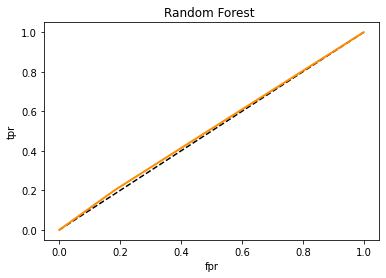

In [31]:
#Evaluate random forest 
getModelReport("Random Forest ", y_test, forest_y_predict)
plot_roc_curve("Random Forest ",y_test, forest_y_predict)


In [32]:
#Predict the model with xGBoost with pre-processed data 
xgboost_y_predict = predict_with_xGBoost(X_train_encode, y_train, X_test_encode)





xGBoost TRAIN ACCURACY:  0.694185524872894




*************************************************************************************
FOR XGBoost :
TEST ACCURACY: 0.694163385336191
F1 SCORE: 0.0
CONFUSION MATRIX: 
[[13927     0]
 [ 6136     0]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.69      1.00      0.82     13927
           1       0.00      0.00      0.00      6136

    accuracy                           0.69     20063
   macro avg       0.35      0.50      0.41     20063
weighted avg       0.48      0.69      0.57     20063

****************************************************************************************
AUC roc_auc_score: 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


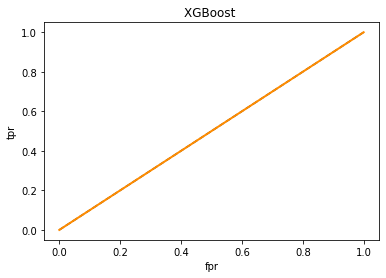

In [33]:
#Evaluate xGBoost 
getModelReport("XGBoost ", y_test, xgboost_y_predict)
plot_roc_curve("XGBoost ",y_test, xgboost_y_predict)

In [34]:
#Predict the model with decision tree with pre-processed data without SMOTE
dt_y_predict = predict_with_decisionTree(X_train_encode, y_train, X_test_encode)






Decision Tree: TRAIN ACCURACY:  0.8779284218921344




*************************************************************************************
FOR Decison Tree :
TEST ACCURACY: 0.6038478791805811
F1 SCORE: 0.2781108083560399
CONFUSION MATRIX: 
[[10584  3343]
 [ 4605  1531]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.70      0.76      0.73     13927
           1       0.31      0.25      0.28      6136

    accuracy                           0.60     20063
   macro avg       0.51      0.50      0.50     20063
weighted avg       0.58      0.60      0.59     20063

****************************************************************************************
AUC roc_auc_score: 0.5047368722962132


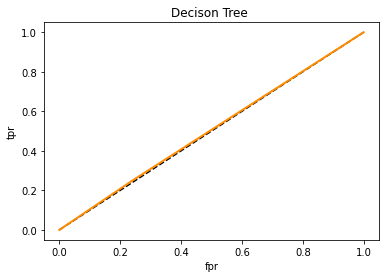

In [35]:
#Evaluate decision tree without SMOTE
getModelReport("Decison Tree ", y_test, dt_y_predict)
plot_roc_curve("Decison Tree ",y_test, dt_y_predict)

In [36]:
#Predict the model with SVM with pre-processed data without SMOTE
svm_y_predict = predict_with_SVM(X_train_encode, y_train, X_test_encode)





SVM: TRAIN ACCURACY:  0.6157038181636926


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




*************************************************************************************
FOR SVM :
TEST ACCURACY: 0.6150127099636146
F1 SCORE: 0.20990180032733222
CONFUSION MATRIX: 
[[11313  2614]
 [ 5110  1026]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.69      0.81      0.75     13927
           1       0.28      0.17      0.21      6136

    accuracy                           0.62     20063
   macro avg       0.49      0.49      0.48     20063
weighted avg       0.56      0.62      0.58     20063

****************************************************************************************
AUC roc_auc_score: 0.4897584691231771


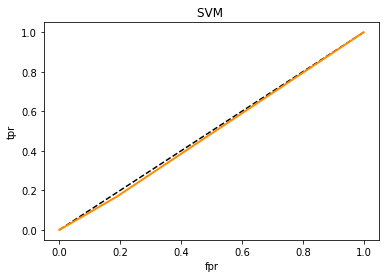

In [37]:
#Evaluate SVM 
getModelReport("SVM ", y_test, svm_y_predict)
plot_roc_curve("SVM ",y_test, svm_y_predict)

KNN TRAIN ACCURACY:  0.7427724055428173


*************************************************************************************
FOR KNeighbors :
TEST ACCURACY: 0.6324577580621044
F1 SCORE: 0.25993576876756325
CONFUSION MATRIX: 
[[11394  2533]
 [ 4841  1295]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.70      0.82      0.76     13927
           1       0.34      0.21      0.26      6136

    accuracy                           0.63     20063
   macro avg       0.52      0.51      0.51     20063
weighted avg       0.59      0.63      0.60     20063

****************************************************************************************
AUC roc_auc_score: 0.5145863069858863


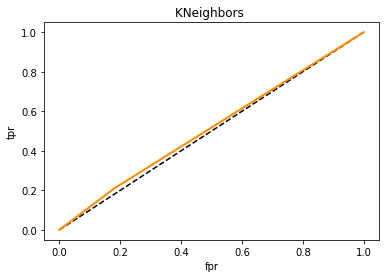

In [38]:
# KNN model requires you to specify n_neighbors,
# the number of points the classifier will look at to determine what class a new point belongs to
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
KNN_model.fit(X_train_encode, y_train)

knn_y_predict_train = KNN_model.predict(X_train_encode)
train_acc = accuracy_score(y_train, knn_y_predict_train)
print ("KNN TRAIN ACCURACY: ",train_acc )

#Test Accuracy
KNN_prediction = KNN_model.predict(X_test_encode)
getModelReport("KNeighbors ", y_test, KNN_prediction)
plot_roc_curve("KNeighbors ",y_test, KNN_prediction)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)




*************************************************************************************
FOR LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False):
TEST ACCURACY: 0.694163385336191
F1 SCORE: 0.00032583903551645487
CONFUSION MATRIX: 
[[13926     1]
 [ 6135     1]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.69      1.00      0.82     13927
           1       0.50      0.00      0.00      6136

    accuracy                           0.69     20063
   macro avg       0.60      0.50      0.41     20063
weighted avg       0.63      0.69      0.57     20063

****************************************************************************************
AUC roc_auc_score: 0.5000

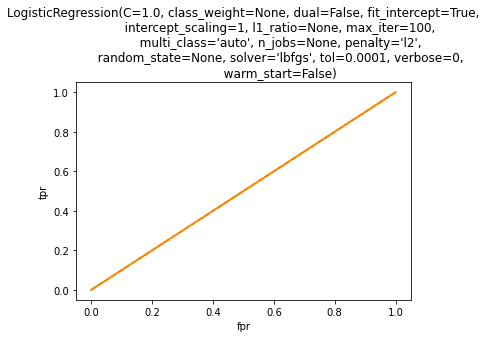



*************************************************************************************
FOR AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None):
TEST ACCURACY: 0.6941135423416239
F1 SCORE: 0.0009767214715936839
CONFUSION MATRIX: 
[[13923     4]
 [ 6133     3]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.69      1.00      0.82     13927
           1       0.43      0.00      0.00      6136

    accuracy                           0.69     20063
   macro avg       0.56      0.50      0.41     20063
weighted avg       0.61      0.69      0.57     20063

****************************************************************************************
AUC roc_auc_score: 0.5001008529856136


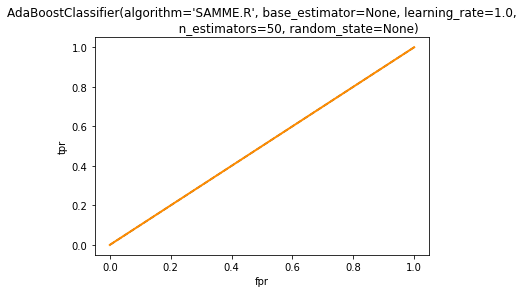



*************************************************************************************
FOR GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False):
TEST ACCURACY: 0.694163385336191
F1 SCORE: 0.00032583903551645487
CONFUSION MATRIX: 
[[13926     1]
 [ 6135     1]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0   

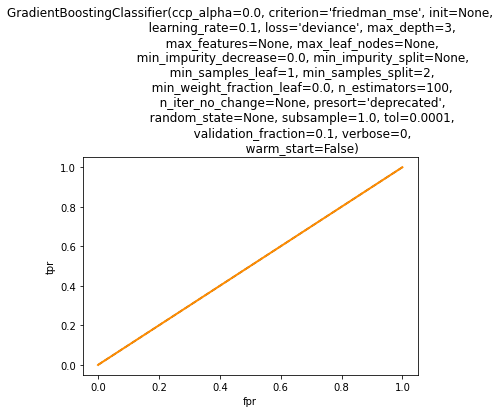

,Modelling Algorithm,Train Accuracy,Validation Accuracy,Difference
0,LogisticRegression,0.694260,0.694163,0.013958
2,GradientBoostingClassifier,0.694360,0.694163,0.028314
1,AdaBoostClassifier,0.694186,0.694114,0.010369


In [39]:
models = [LogisticRegression(), AdaBoostClassifier(), GradientBoostingClassifier()]
model_names = ['LogisticRegression', 'AdaBoostClassifier', 'GradientBoostingClassifier']
accuracy_train = []
accuracy_val = []
for model in models:
    mod = model
    mod.fit(X_train_encode, y_train)
    y_pred_train = mod.predict(X_train_encode)
    y_pred_test = mod.predict(X_test_encode)
    accuracy_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_val.append(accuracy_score(y_test, y_pred_test))
    getModelReport(mod, y_test, y_pred_test)
    plot_roc_curve(mod,y_test, y_pred_test)
data = {'Modelling Algorithm' : model_names, 'Train Accuracy' : accuracy_train, 'Validation Accuracy' : accuracy_val}
data = pd.DataFrame(data)
data['Difference'] = ((np.abs(data['Train Accuracy'] - data['Validation Accuracy'])) * 100)/(data['Train Accuracy'])
data.sort_values(by = 'Validation Accuracy', ascending = False)